Using device: cpu

--- Training Model 1/5 ---
Epoch [1/100], Train Loss: 225.2451, Val Loss: 49.0188
Validation loss decreased (inf --> 49.0188). Saving model to ./model/cnn/血红蛋白回归预测模型_1.pth
Epoch [2/100], Train Loss: 66.5426, Val Loss: 34.9933
Validation loss decreased (49.0188 --> 34.9933). Saving model to ./model/cnn/血红蛋白回归预测模型_1.pth
Epoch [3/100], Train Loss: 35.5997, Val Loss: 40.4914
EarlyStopping counter: 1 out of 10
Epoch [4/100], Train Loss: 25.7805, Val Loss: 17.2181
Validation loss decreased (34.9933 --> 17.2181). Saving model to ./model/cnn/血红蛋白回归预测模型_1.pth
Epoch [5/100], Train Loss: 13.2194, Val Loss: 10.3544
Validation loss decreased (17.2181 --> 10.3544). Saving model to ./model/cnn/血红蛋白回归预测模型_1.pth
Epoch [6/100], Train Loss: 7.9311, Val Loss: 5.4021
Validation loss decreased (10.3544 --> 5.4021). Saving model to ./model/cnn/血红蛋白回归预测模型_1.pth
Epoch [7/100], Train Loss: 7.4118, Val Loss: 11.4247
EarlyStopping counter: 1 out of 10
Epoch [8/100], Train Loss: 8.3648, Val Loss

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4316\3431204396.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location


--- Evaluation Metrics ---
Mean Squared Error (MSE): 0.7808
Root Mean Squared Error (RMSE): 0.8836
Mean Absolute Error (MAE): 0.6953
R-squared (R2): 0.9727


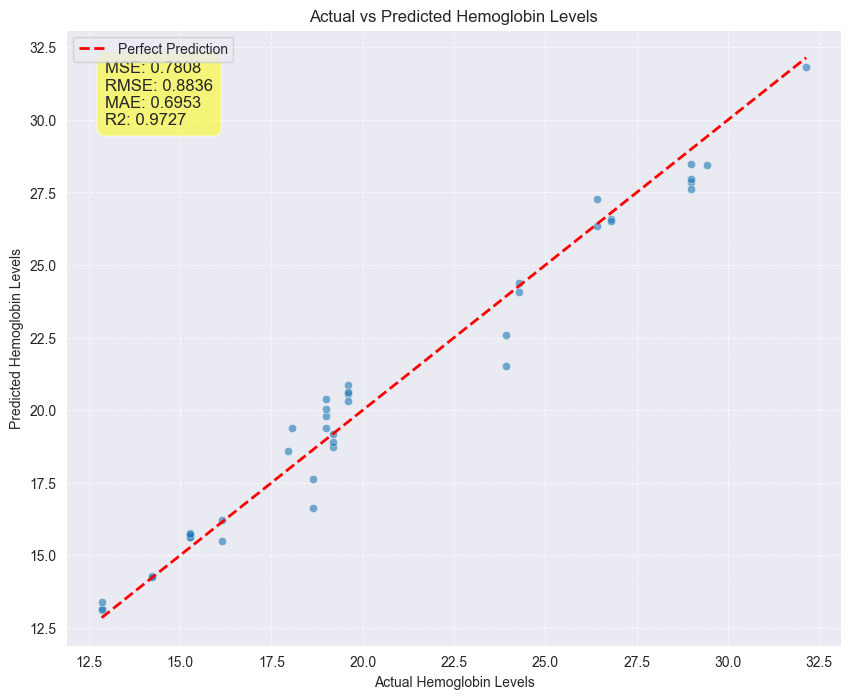

In [8]:
import torch.nn.functional as F  # 导入 F 模块
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 1. 配置和初始化 ---

# 定义图像预处理流程
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 将图像缩放至64x64像素
    transforms.ToTensor(),  # 将图像转换为PyTorch张量
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 图像归一化，根据你的数据集调整
])

# 设置设备 (GPU 如果可用，否则使用 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. 数据集和数据加载器定义 ---

# 定义数据集类
class HemoglobinImageDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        """
        初始化数据集类，设置数据、图像目录路径及图像变换
        :param data: 包含图像名和标签的数据框
        :param image_dir: 图像所在目录
        :param transform: 应用于图像的变换
        """
        self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        """
        返回数据集长度
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        获取指定索引处的数据项
        :param idx: 数据项索引
        :return: 图像及其对应的标签
        """
        img_name = self.data.iloc[idx, 0]  # 假设第一列为图像文件名
        label = self.data.iloc[idx, 1]  # 假设第二列为标签（血红蛋白浓度）

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")  # 打开并转换图像为RGB模式

        if self.transform:
            image = self.transform(image)  # 如果定义了变换，则对图像应用变换

        return image, torch.tensor(label, dtype=torch.float32)  # 返回图像张量和标签张量

# --- 3. 模型定义 ---

# 定义模型
class HemoglobinPredictor(nn.Module):
    def __init__(self):
        super(HemoglobinPredictor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # 第一个卷积层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 最大池化层
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 第二个卷积层
        self.fc1 = nn.Linear(32 * 16 * 16, 120)  # 全连接层1
        self.fc2 = nn.Linear(120, 84)  # 全连接层2
        self.fc3 = nn.Linear(84, 1)  # 输出层

    def forward(self, x):
        """
        定义前向传播过程
        :param x: 输入张量
        :return: 输出张量
        """
        x = self.pool(F.relu(self.conv1(x)))  # 卷积->激活->池化
        x = self.pool(F.relu(self.conv2(x)))  # 卷积->激活->池化
        x = x.view(-1, 32 * 16 * 16)  # 展平张量
        x = F.relu(self.fc1(x))  # 全连接->激活
        x = F.relu(self.fc2(x))  # 全连接->激活
        x = self.fc3(x)  # 输出层
        return x

# --- 4. 早停机制 ---

# 定义早停类
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='best_model.pth'):
        """
        初始化早停类
        :param patience: 容忍没有改进的最大轮数
        :param delta: 改进的最小差值
        :param path: 模型保存路径
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        """
        在每个验证阶段调用此方法来检查是否需要早停
        :param val_loss: 验证损失
        :param model: 当前模型
        """
        score = -val_loss  # 负的验证损失作为评分标准
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """
        保存模型的最佳状态
        :param val_loss: 当前验证损失
        :param model: 当前模型
        """
        if val_loss < self.val_loss_min: # 只有当验证损失确实降低时才保存模型
            torch.save(model.state_dict(), self.path)
            print(f"Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}). Saving model to {self.path}")
            self.val_loss_min = val_loss

# --- 5. 训练和预测函数 ---

# 定义训练模型的函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, model_path='血红蛋白回归预测模型_1.pth'):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param criterion: 损失函数
    :param optimizer: 优化器
    :param num_epochs: 训练轮数
    :param patience: 早停耐心值
    :param model_path: 模型保存路径
    """
    early_stopping = EarlyStopping(patience=patience, delta=0.0001, path=model_path)
    model.to(device) # 将模型移动到指定设备

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # 将数据移动到指定设备

            optimizer.zero_grad()  # 清空梯度
            outputs = model(inputs).squeeze()  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新权重
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device) # 将数据移动到指定设备
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}')

        early_stopping(val_loss, model)  # 检查早停条件
        if early_stopping.early_stop:
            print("Early stopping")
            break

# 定义预测函数
def predict(models, dataloader):
    """
    使用多个模型进行预测，并计算平均预测值
    :param models: 模型列表
    :param dataloader: 数据加载器
    :return: 预测值数组和真实标签数组
    """
    predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device) # 将数据移动到指定设备
            batch_predictions = [model(inputs).squeeze().cpu().numpy() for model in models] # 将预测结果移回 CPU
            mean_predictions = np.mean(batch_predictions, axis=0)
            predictions.extend(mean_predictions)
            all_labels.extend(labels.numpy())
    return np.array(predictions), np.array(all_labels)

# --- 6. 主执行流程 ---

if __name__ == "__main__":
    # 读取数据
    data = pd.read_csv('./train/血红蛋白浓度值.csv')  # 从CSV文件中加载数据

    # 创建数据集实例
    dataset = HemoglobinImageDataset(
        data=data,
        image_dir='./train/processed_images',  # 指定图像目录
        transform=transform  # 使用前面定义的变换
    )

    # 划分训练集和测试集
    train_size = int(0.8 * len(dataset))  # 训练集占80%
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])  # 随机划分数据集

    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # 训练集加载器
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)  # 测试集加载器

    # 创建模型保存目录
    model_dir = './model/cnn/'
    os.makedirs(model_dir, exist_ok=True)
    # 设置训练多个模型
    num_models = 5
    model_paths = [model_dir+f'血红蛋白回归预测模型_{i}.pth' for i in range(1, num_models + 1)]

    # 训练所有模型
    for i in range(num_models):
        print(f"\n--- Training Model {i+1}/{num_models} ---")
        model = HemoglobinPredictor()
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器
        criterion = nn.MSELoss()  # 均方误差损失
        train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100, patience=10, model_path=model_paths[i])

    # 加载所有模型
    print("\n--- Loading trained models for prediction ---")
    models = []
    for path in model_paths:
        model = HemoglobinPredictor()
        # 确保模型在加载状态字典之前移动到正确的设备
        model.to(device)
        model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
        model.eval()  # 设置为评估模式
        models.append(model)

    # 进行预测
    predictions, all_labels = predict(models, test_loader)

    # 计算评价指标
    mse = mean_squared_error(all_labels, predictions)
    rmse = np.sqrt(mse) # 计算 RMSE
    mae = mean_absolute_error(all_labels, predictions) # 计算 MAE
    r2 = r2_score(all_labels, predictions)

    print(f'\n--- Evaluation Metrics ---')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'R-squared (R2): {r2:.4f}')

    # 可视化结果
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=all_labels, y=predictions, alpha=0.6)  # 绘制散点图，增加透明度
    plt.xlabel('Actual Hemoglobin Levels')  # 实际血红蛋白水平
    plt.ylabel('Predicted Hemoglobin Levels')  # 预测血红蛋白水平
    plt.title('Actual vs Predicted Hemoglobin Levels')  # 图标题
    # 绘制对角线
    min_val = min(min(all_labels), min(predictions))
    max_val = max(max(all_labels), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

    # 在图上显示指标
    plt.text(0.05, 0.95, f'MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR2: {r2:.4f}', transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7) # 添加网格线
    plt.show()  # 显示图形

In [1]:
# -*- coding: utf-8 -*-
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F  # 导入 F 模块
from utils import get_model_transform, get_model_model, get_test_dataset_class
# -*- coding: utf-8 -*-
import os
import sys
from utils import preprocess_images, crop_red_area, process_image

# 输入和输出目录（基于项目根目录）
origin_input_dir = os.path.join('pred', 'origin_images')
red_cropped_output_dir = os.path.join('pred', 'red_cropped_images')
processed_output_dir = os.path.join('pred', 'processed_images')

# 创建必要的输出目录
for dir_path in [origin_input_dir, red_cropped_output_dir, processed_output_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory created: {dir_path}")

# 第一步：处理原始图像，裁剪红色区域
preprocess_images(origin_input_dir, red_cropped_output_dir, crop_red_area)

# 第二步：对裁剪后的红色区域图像进行二次加工
preprocess_images(red_cropped_output_dir, processed_output_dir, process_image)
# 载入图像预处理转换、神经网络模型和数据集类
transform = get_model_transform()
TestHemoglobinImageDataset = get_test_dataset_class()
# 实例化测试数据集
test_image_dir = 'pred/test/processed_images'
test_dataset = TestHemoglobinImageDataset(image_dir=test_image_dir, transform=transform)
# 创建数据加载器
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 载入多个模型
model_dir = './model/cnn/'
os.makedirs(model_dir, exist_ok=True)
# 设置训练多个模型
num_models = 5
model_paths = [model_dir+f'血红蛋白回归预测模型_{i}.pth' for i in range(1, num_models + 1)]
# 加载所有模型
models = [get_model_model() for _ in range(len(model_paths))]
for model, path in zip(models, model_paths):
    model.load_state_dict(torch.load(path,weights_only=True))
    model.eval()  # 将模型设置为评估模式

# 预测
all_preds = []
all_img_names = []

with torch.no_grad():
    for inputs, img_names in test_loader:
        batch_predictions = [model(inputs).squeeze().numpy() for model in models]
        mean_predictions = np.mean(batch_predictions, axis=0)
        if mean_predictions.ndim == 0:  # 如果 mean_predictions 是一个标量
            all_preds.append(mean_predictions.item())  # 使用 .item() 转换为 Python 标量
        else:
            all_preds.extend(mean_predictions)  # 对于非标量张量，直接扩展列表
        all_img_names.extend(img_names)

# 创建结果DataFrame
results = pd.DataFrame({
    'Algorithm':'CNN',
    'Image': all_img_names,
    'Predicted Hemoglobin Level': all_preds
})
print(results)
# 保存结果
results.to_csv('./pred/血红蛋白浓度预测值.csv', index=False)
print("预测完成，结果已保存至 ./test/血红蛋白浓度预测值.csv")

Processed and saved: pred\red_cropped_images\1 (1).JPG1 (1).JPG
Processed and saved: pred\red_cropped_images\1 (10).JPG1 (10).JPG
Processed and saved: pred\red_cropped_images\1 (2).JPG1 (2).JPG
Processed and saved: pred\red_cropped_images\1 (3).JPG1 (3).JPG
Processed and saved: pred\red_cropped_images\1 (4).JPG1 (4).JPG
Processed and saved: pred\red_cropped_images\1 (5).JPG1 (5).JPG
Processed and saved: pred\red_cropped_images\1 (6).JPG1 (6).JPG
Processed and saved: pred\red_cropped_images\1 (7).JPG1 (7).JPG
Processed and saved: pred\red_cropped_images\1 (8).JPG1 (8).JPG
Processed and saved: pred\red_cropped_images\1 (9).JPG1 (9).JPG
Processed and saved: pred\red_cropped_images\10 (1).JPG10 (1).JPG
Processed and saved: pred\red_cropped_images\10 (10).JPG10 (10).JPG
Processed and saved: pred\red_cropped_images\10 (2).JPG10 (2).JPG
Processed and saved: pred\red_cropped_images\10 (3).JPG10 (3).JPG
Processed and saved: pred\red_cropped_images\10 (4).JPG10 (4).JPG
Processed and saved: pred\